In [1]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.special import gamma



imports work


In [5]:
def dead_channels(run_number):

    # extract the file
    infile_name = f'TB_FIRE\TB_reco\TB_FIRE_{run_number}_raw_reco_diagnostics.root'
    infile = uproot.open(infile_name)

    # get the Good/Bad channels list
    isgood = infile['Diagnostics;1']['BadChannelResults']['isGood']

    # turn it to ak array
    isgood_arr = ak.Array(isgood.array())

    # divide it to planes:
    isgood_planes = ak.unflatten(isgood_arr, 256)

    # get the index of dead channels in each plane (0 to 255)

    # translate indices to (x,y)



<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:4: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_12896\4175026528.py:4: SyntaxWarning: invalid escape sequence '\T'
  infile_name = f'TB_FIRE\TB_reco\TB_FIRE_{run_number}_raw_reco_diagnostics.root'


In [2]:
hit_data_1093 = rf.get_ROOT_data_zip_RECO(1093)

1093 RECONSTRUCTED finished


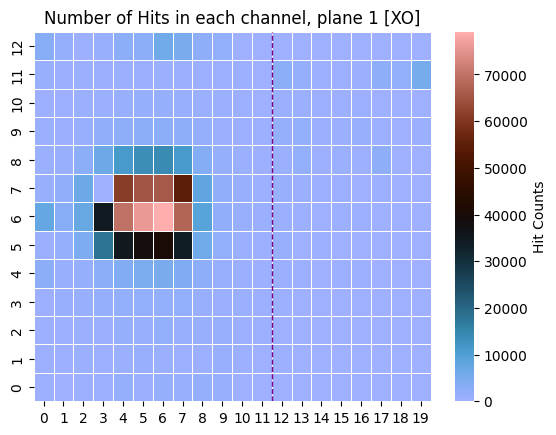

In [12]:
rf.hits_amount_colormap_single_plane(hit_data_1093,1)

In [10]:
# returns histogram of the energie of events starting at the stated X position
def shower_energy_histo_single_location(hit_data, Position, specific_Y = "all_rows",bin_size = 50):

    # get only showers starting at the first plane to identify the initial location
    plane_7 = hit_data[hit_data.plane == 7]
    mask = ak.num(plane_7) == 1
    first_plane_starting_events = hit_data[mask]

    # determine the initial location of the shower
    # get the data on the first plane
    plane_7_clean = plane_7[mask]
    plane_7_channel = plane_7_clean.ch

    # divide by x positions
    y, x = divmod(plane_7_channel, 20) #y is the quontinent and is the row, x is the remainder and column
    x_list = x.to_list()
    x_ak = ak.Array(x_list)
    x_avg = ak.mean(x_ak, axis = 1)
    
    # compute the shower energy for each event
    hit_amp_array = first_plane_starting_events.amp
    event_shower_amp_array = ak.sum(hit_amp_array, axis = 1)

    # Filter for specific row only
    if specific_Y  != "all_rows":
        y = ak.flatten(y)
        mask_Y = y == specific_Y
        x_avg = x_avg[mask_Y]
        event_shower_amp_array = event_shower_amp_array[mask_Y]
        title = f'Energy Histograms for events starting at different initial columns, y = {specific_Y}'
    
    
    
    # get the shower energy for the X position for all events
    amps_divided_by_class, avg_amps, classes = rf.ak_groupby(x_avg, event_shower_amp_array)
    
    amps_class_position = amps_divided_by_class[amps_divided_by_class.classes == Position]
    amps_position = amps_class_position.data
    amps_position_clean = ak.flatten(amps_position[ak.num(amps_position) > 0])
    
    

    # Histogram
    max_range = 12000
    range = (0, max_range)
    bins = np.arange(0, max_range + 1, bin_size)
    
    # most common energy (peak of the histo)
    counts, bins = np.histogram(amps_position_clean, bins = bins, range=range)
    peak_idx = np.argmax(counts)
    peak_center = (bins[peak_idx] + bins[peak_idx + 1]) / 2
    

    # Histo Mean
    avg_amp = ak.mean(amps_position_clean)
    
    # Histo Standard deveiation (how spread is the data) marked as sigma
    std = ak.std(amps_position_clean)

    # standard deviation error of mean (how uncertain the mean is) marked as sigma_mean
    SEM = std/np.sqrt(len(amps_position_clean))
    


    # Multi-line string for the box
    textstr = '\n'.join((
        f'Mean = {avg_amp:.2f}',
        f'Peak = {peak_center:.2f}',
        rf'$\sigma$ = {std:.2f}',
        rf'$\sigma_{{\mu}}$ = {SEM:.2f}',
        # f'RMS = {RMS:.2f}',
        # f'STD = {STD:,}'
    ))

    # Place the box inside the axes
    plt.text(
        0.65, 0.75, textstr, transform=plt.gca().transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )


    # plot the histogram with matplotlib
    plt.hist(amps_position_clean, bins = bins, range=range, label=f"avg = {avg_amp} \n peak = {peak_center}")
    plt.grid()
    plt.xlabel(f"Energy in Column {Position}")
    plt.ylabel("Counts")
    plt.title(f'Energy Histograms for events starting at different initial columns, y =  {specific_Y}')
    plt.show()


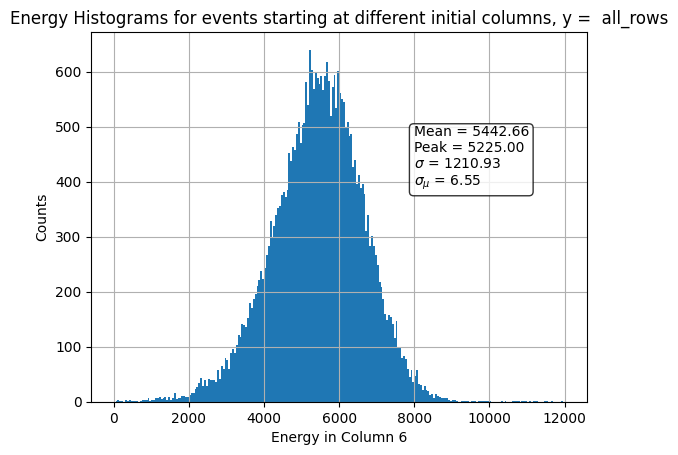

In [11]:
shower_energy_histo_single_location(hit_data_1093, 6, bin_size=50)


In [12]:
# rf.Single_column_snergy_histo_Gaussian_fit(hit_data_1093, 6, bin_size=5)

In [13]:
# rf.single_column_energy_Gamma_fit(hit_data_1093, 6, bin_size=5)

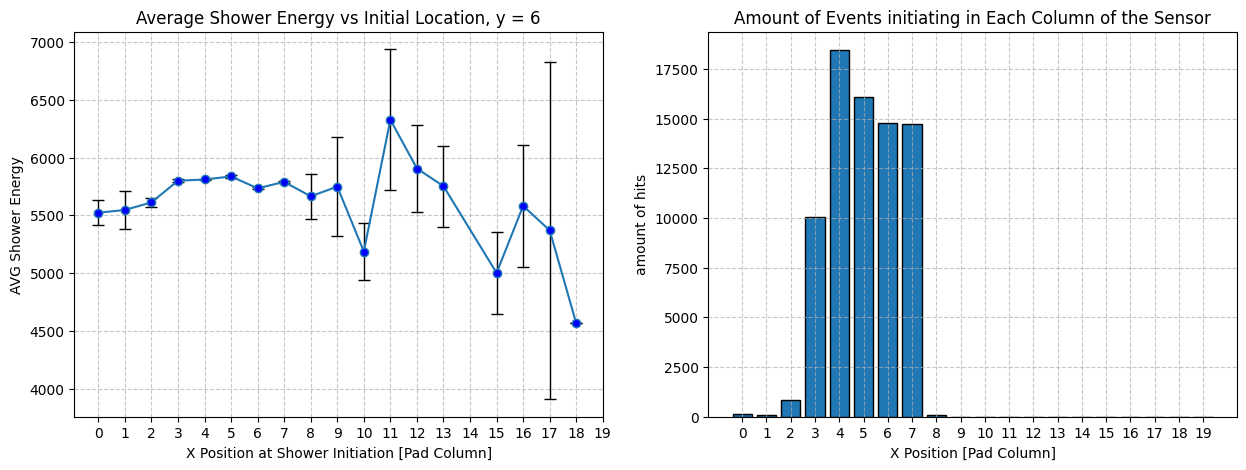

In [9]:
event_shower_energy_vs_X_position(hit_data_1093, single_pad_only = "true", specific_Y=6)